<a href="https://colab.research.google.com/github/monsieurshiva/AdvancedDeepLearning/blob/main/GenerativeDeepLearning/GAN_Cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Dropout
import math
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Create the Discriminator

Leaky RELUs represent an attempt to solve the dying ReLU” problem. This situation occurs when the neurons get stuck in a state in which RELU units always output 0s for all inputs. For these cases, the gradients are completely shut to flow back through the network.

In [ ]:
def define_discriminator(in_shape=[32,32,3]):
  model=Sequential()
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same',input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))

  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,metrics='accuracy')
  return model

In [ ]:
8*8*128

8192

In [ ]:
def define_generator(latent_dim):
  model=Sequential()
  n_nodes=8*8*128 # 8192 neurons we are generating
  model.add(Dense(n_nodes,input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((8,8,128)))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3,(8,8),activation='tanh',padding='same'))
  return model

In [ ]:
def define_gan(generator,discriminator):
  discriminator.trainable=False  #Discriminator is trained seperately
  #connect generator and discriminator
  model=Sequential()
  model.add(generator)
  model.add(discriminator)
  #compile model
  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model


In [ ]:
(trainX,trainy),(testX,testy)=load_data()


In [ ]:
trainX.shape

(50000, 32, 32, 3)

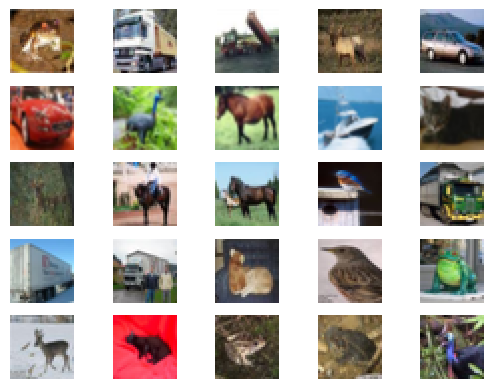

In [ ]:
for i in range(25):
  plt.subplot(5,5,1+i)
  plt.axis('off')
  plt.imshow(trainX[i])
plt.show()

In [ ]:
def load_real_samples():
  (trainX,_),(_,_)=load_data()
  #convert to float and scale
  X=trainX.astype('float32')
  #scale from [0,255] to [-1,1] (generator uses tanh activation)
  X=(X-127.5)/127.5
  return X

In [ ]:
#pick a batch of random real samples to train the gan
#Half batch of real (label=1) and half batch of fake (label=0)
def generate_real_samples(dataset,n_samples):
  ix=np.random.randint(0,dataset.shape[0],n_samples)
  X=dataset[ix]
  y=np.ones((n_samples,1))
  return X,y

In [ ]:
def generate_latent_points(latent_dim,n_samples):
  x_input=np.random.randn(latent_dim*n_samples)
  #reshape into a batch of inputs for the network
  x_input=x_input.reshape(n_samples,latent_dim)
  return x_input

In [ ]:
def generate_fake_samples(generator,latent_dim,n_samples):
  x_input=generate_latent_points(latent_dim,n_samples)
  #predict using generator to predict fake samples
  X=generator.predict(x_input)
  y=np.zeros((n_samples,1))
  return X,y

In [ ]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=100,n_batch=128):
  bat_per_epo=int(dataset.shape[0]/n_batch)
  half_batch=int(n_batch/2)
  #the discriminator model is updated for a half batch of real samples and half batch of fake samples, combained a single batch
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real,y_real=generate_real_samples(dataset,half_batch)#get some real images
      d_loss_real,_=d_model.train_on_batch(X_real,y_real) #update D weights on real images
      X_fake,y_fake=generate_fake_samples(g_model,latent_dim,half_batch)#get fake images
      d_loss_fake,_=d_model.train_on_batch(X_fake,y_fake) #update D weights on fake images
      X_gan=generate_latent_points(latent_dim,n_batch)#input for generator
      y_gan=np.ones((n_batch,1)) #Label generated images as true to trick the discriminator
      g_loss=gan_model.train_on_batch(X_gan,y_gan)
      print('Epoch>%d,Batch %d%d,d1=%.3f,d2=%.3f,g=%.3f' %(i+1,j+1,bat_per_epo,d_loss_real,d_loss_fake,g_loss))
  g_model.save('/content/drive/My Drive/DL/ADL/GAN/cifar_GAN_epoch50.h5')



In [ ]:
#train the GAN
latent_dim=100
discriminator=define_discriminator()
generator=define_generator(latent_dim)
gan_model=define_gan(generator,discriminator)
dataset=load_real_samples()
train(generator,discriminator,gan_model,dataset,latent_dim,n_epochs=50)


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 11ms/step
Epoch>44,Batch 231390,d1=0.697,d2=0.683,g=0.731
2/2 [==============================] - 0s 5ms/step
Epoch>44,Batch 232390,d1=0.692,d2=0.676,g=0.740
2/2 [==============================] - 0s 4ms/step
Epoch>44,Batch 233390,d1=0.695,d2=0.664,g=0.740
2/2 [==============================] - 0s 8ms/step
Epoch>44,Batch 234390,d1=0.691,d2=0.679,g=0.730
2/2 [==============================] - 0s 4ms/step
Epoch>44,Batch 235390,d1=0.696,d2=0.683,g=0.714
2/2 [==============================] - 0s 4ms/step
Epoch>44,Batch 236390,d1=0.695,d2=0.687,g=0.714
2/2 [==============================] - 0s 4ms/step
Epoch>44,Batch 237390,d1=0.697,d2=0.691,g=0.707
2/2 [==============================] - 0s 4ms/step
Epoch>44,Batch 238390,d1=0.698,d2=0.698,g=0.703
2/2 [==============================] - 0s 4ms/step
Epoch>44,Batch 239390,d1=0.696,d2=0.698,g=0.706
2/2 [==============================] - 0s 5ms/step
Epoch>

Epoch>50,Batch 390390,d1=0.694,d2=0.697,g=0.703


In [ ]:
#Let us load the generator model and generate images
from keras.models import load_model


In [ ]:
#plot the generated images
def show_plot(examples,n):
  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.axis('off')
    plt.imshow(examples[i,:,:,:])
  plt.show()


1/1 [==============================] - 8s 8s/step


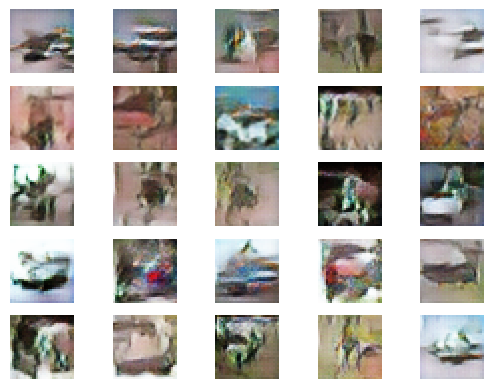

In [ ]:
model=load_model('/content/drive/My Drive/DL/ADL/GAN/cifar_GAN_epoch50.h5')
latent_points=generate_latent_points(100,25)
X=model.predict(latent_points)
#scale from [-1, 1] to [0,1]
X=(X+1)/2.0
X=(X*255).astype(np.uint8)
show_plot(X,5)